In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)


# Lecture 07 - Permutation Testing

## DSC 80, Fall 2022

## Today, in DSC 80...

- Permutation testing: differences between groups.
- Speeding up permutation tests.

## Announcements 📣

- 

## Permutation Testing

### Review: Hypothesis testing

- In "vanilla" hypothesis testing, we are given a **single** observed sample, and are asked to make an assumption as to how it came to be.
    - This assumption is the **null hypothesis**.
    - This assumption must be a **probability model**, since we use it to generate new data.
- We simulate data under the null hypothesis to answer the question, **if this assumption is true, how likely is the given observation?**

### Examples so far

So far, our hypothesis tests have assessed a model given a **single** random sample.


- We flip a coin 400 times. Are the flips consistent with the coin being fair?
    - Null distribution: the coin is 50/50. This is a **probability model** that we can sample from.

- Do UCSD students look like a random sample of California residents?
    - Null distribution: ethnicities of California residents (e.g. 17% Asian, 3% Black, etc.). This is a **probability model** that we can sample from.

- Do the bill lengths of penguins on Torgersen Island look like a random sample of all bill lengths?
    - Null distribution: bill lengths of all penguins. We can **sample** from this distribution.

### Today's lecture

Often have **two** random samples we wish to compare.
- Outcomes of patients assigned to control group and treatment group in a pharmaceutical study.
- Number of clicks from people who saw version A of an advertisement vs. version B.
- Pressure drops in New England Patriots footballs vs. Indianapolis Colts footballs.

### Permutation testing

* **Given two observed samples, are they fundamentally different, or could they have been generated by the same process?**
* In a permutation test, we decide whether two **fixed** random samples come from the same distribution.
- Unlike in the previous hypothesis testing examples, when conducting a permutation test, you do not know **what distribution** generated your two samples!


## Example: Birth weight and smoking 🚬

### Birth weight and smoking

- Is there a significant difference in the weights of babies born to mothers who smoke, vs. non-smokers?
- We have two groups:
    - Babies whose mothers smoked during pregnancy.
    - Babies whose mothers did not smoke during pregnancy.
- In each group, the relevant attribute is the birth weight of the baby. 

Let's start by loading in data.

In [2]:
# Kaiser dataset, 70s 
import os
baby_fp = os.path.join('data', 'baby.csv')
baby = pd.read_csv(baby_fp)
baby.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


Only the `'Birth Weight'` and `'Maternal Smoker'` columns are relevant.

In [3]:
smoking_and_birthweight = baby[['Maternal Smoker', 'Birth Weight']]
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


### Exploratory data analysis

How many babies are in each group?

In [4]:
smoking_and_birthweight.groupby('Maternal Smoker').count()

,Birth Weight
Maternal Smoker,
False,715
True,459


What is the average birth weight within each group?

In [5]:
smoking_and_birthweight.groupby('Maternal Smoker').mean()

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


Note that 16 ounces are in 1 pound, so the above weights are ~7-8 pounds.

### Visualizing birth weight distributions

- Below, we draw the distribution of birth weights, separated by mother's smoking status.
- The histograms appear to be different, but is the difference possible **due to random chance** or is there a significant difference in the two distributions?

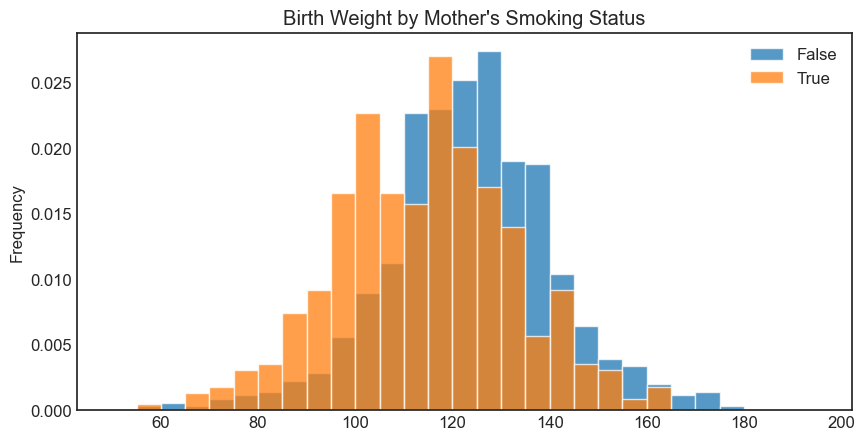

In [6]:
title = "Birth Weight by Mother's Smoking Status"

(
    smoking_and_birthweight
    .groupby('Maternal Smoker')['Birth Weight']
    .plot(kind='hist', density=True, legend=True,
          ec='w', bins=np.arange(50, 200, 5), alpha=0.75,
          title=title)
);    

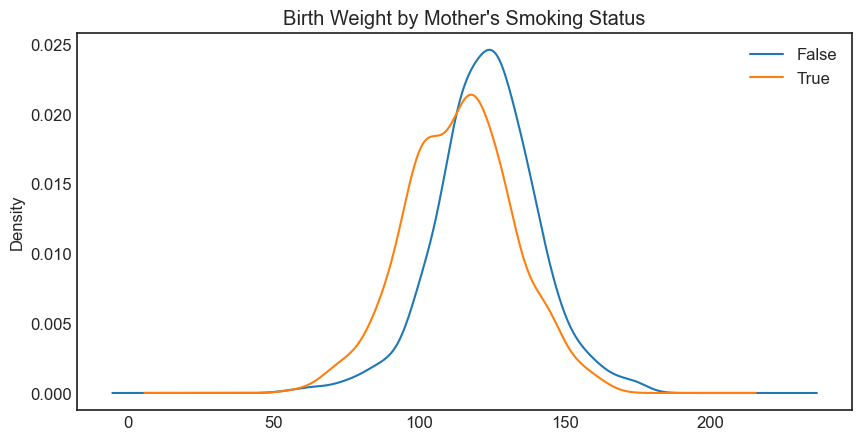

In [7]:
(
    smoking_and_birthweight
    .groupby('Maternal Smoker')['Birth Weight']
    .plot(kind='kde', legend=True,
          title=title)
);    

### The setup

- **Null hypothesis**: In the population, birth weights of smokers and non-smokers have the same distribution. The difference we saw was due to random chance.
- **Alternative hypothesis**: In the population, babies born to smokers have lower birth weights, on average.

- Like in all of our previous hypothesis tests, we need to **simulate data under the null**.
- But unlike our in our previous hypothesis tests, we don't know what the null distribution is!
- Keep this thought in mind, we will revisit it momentarily.

### Alternative hypothesis: birth weights come from *different* distributions...

- ...and babies born to mothers who smoke weigh significantly less.
- Our alternative hypothesis states that when generating birth weights, "nature" looks at whether mother smoked.
    - By "nature" here, we mean the **data generating process**.

<center><img src='imgs/alt-hyp.png' width=40%></center>

### Null hypothesis: birth weights come from the *same* distribution
- Our null hypothesis states that "smoker" / "non-smoker" labels have no relationship to birth weight. 
     - In other words, the "smoker" / "non-smoker" labels **may well have** been assigned at random.

<center><img src='imgs/null-hyp.png' width=60%></center>

### Choosing a test statistic

We need a test statistic that can measure **how different** two numerical distributions are.

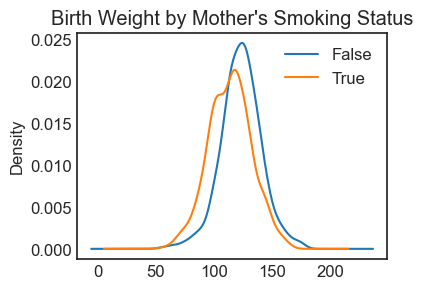

In [8]:
(
    smoking_and_birthweight
    .groupby('Maternal Smoker')['Birth Weight']
    .plot(kind='kde', legend=True,
          title=title,
          figsize=(4, 3))
);    

**Easiest solution:** Difference in group means.

### Difference in group means

To compute the difference between the **mean birth weight of babies born to smokers** and the **mean birth weight of babies born to non-smokers**, we can use `groupby`.

In [9]:
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


In [10]:
means_table = smoking_and_birthweight.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [11]:
means_table.loc[True, 'Birth Weight'] - means_table.loc[False, 'Birth Weight']

-9.266142572024918

Note that we arbitrarily chose to compute the "smoking" mean minus the "non-smoking" mean. We could have chosen the other direction, too.

### Another approach

Insteading of using `.loc` and manually subtracting, there is another method we can use to find the difference in group means – the `diff` Series/DataFrame method.

In [12]:
s = pd.Series([1, 2, 5, 9, 15])
s

0     1
1     2
2     5
3     9
4    15
dtype: int64

In [13]:
s.diff()

0    NaN
1    1.0
2    3.0
3    4.0
4    6.0
dtype: float64

In [14]:
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [15]:
means_table.diff()

,Birth Weight
Maternal Smoker,
False,NaN
True,-9.266143


In [16]:
observed_difference = means_table.diff().iloc[-1, 0]
observed_difference

-9.266142572024918

### Testing through simulation

- We're almost ready to perform our hypothesis test.
    - **Null hypothesis:** In the population, birth weights of smokers and non-smokers have the same distribution. The difference we saw was due to random chance.
    - **Alternative hypothesis:** In the population, babies born to smokers have lower birth weights, on average.
    - **Test statistic:** Difference in group means.

- **Issue:** The null hypothesis doesn't say **what** the distribution is.
    - This is different from the coin flipping, California ethnicity, and bill length examples, because there **the null hypotheses were well-defined probability models**.
    - Here, we can't draw directly from the distribution!
- We have to do something a bit more clever.

### Implications of the null hypothesis

- Under the null hypothesis, both groups are sampled from the same distribution.
- If this is true, then the group label – `'Maternal Smoker'` – has no effect on the birth weight.
- In our dataset, we saw **one assignment** of `True` or `False` to each baby.

In [17]:
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


- Under the null hypothesis, we were just as likely to see **any other** assignment.

### Permutation tests

- In a **permutation test**, we generate new data by **shuffling group labels**.
    - In our current example, this involves randomly assigning **babies to `True` or `False`**, while keeping the same number of `True`s and `False`s as we started with.
- On each shuffle, we'll compute our test statistic (difference in group means).
- If we shuffle many times and compute our test statistic each time, we will approximate the distribution of the test statistic.
- We can them compare our observed statistic to this distribution, as in any other hypothesis test.

### Shuffling

- We want to randomly shuffle the `'Maternal Smoker'` column.
- The DataFrame `sample` method returns a random sample of rows in the DataFrame.
    - To create a permutation, either set `n=df.shape[0]` or `frac=1`.
    - By default, `sample` samples without replacement, which is what we want.

In [18]:
smoking_and_birthweight.sample(frac=1)

,Maternal Smoker,Birth Weight
430,True,68
84,True,125
742,False,131
274,False,119
214,False,125
...,...,...
45,False,122
82,False,138
681,False,133
397,False,120


### Shuffling just one column

- Notice: Each time we call `df.sample`, **both** columns are shuffled together.
    - If baby 386 was assigned to `False`, they will still be assigned to `False` in the shuffled version.
- What we really want is to shuffle just one column of the DataFrame.
    - We can either shuffle the whole DataFrame and then extract one column, **or** extract one column and then shuffle it.
    - Shuffling just a column is quicker.
    - **It doesn't matter which column we shuffle – either way, we will randomly assign babies to `True` or `False`**.

### A single shuffle

In [19]:
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


Remember, it doesn't matter which column we shuffle! Here, we'll shuffle birth weights.

In [20]:
shuffled_weights = (
    smoking_and_birthweight['Birth Weight']
    .sample(frac=1)
    .reset_index(drop=True) # Question: What will happen if we do not reset the index?
)

shuffled_weights.head()

0     63
1     97
2    124
3    117
4    127
Name: Birth Weight, dtype: int64

In [21]:
original_and_shuffled = (
    smoking_and_birthweight
    .assign(**{'Shuffled Birth Weight': shuffled_weights})
)

original_and_shuffled.head(10)

,Maternal Smoker,Birth Weight,Shuffled Birth Weight
0,False,120,63
1,False,113,97
2,True,128,124
3,True,108,117
4,False,136,127
5,False,138,170
6,False,132,148
7,False,120,139
8,True,143,102
9,False,140,91


For details on how `**` works, see [this article](https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/).

### How close are the means of the shuffled groups?

One benefit of shuffling `'Birth Weight'` (instead of `'Maternal Smoker'`) is that grouping by `'Maternal Smoker'` allows us to see all of the following information with a single call to `groupby`.

In [22]:
original_and_shuffled.groupby('Maternal Smoker').mean()

,Birth Weight,Shuffled Birth Weight
Maternal Smoker,,
False,123.085315,119.813986
True,113.819172,118.915033


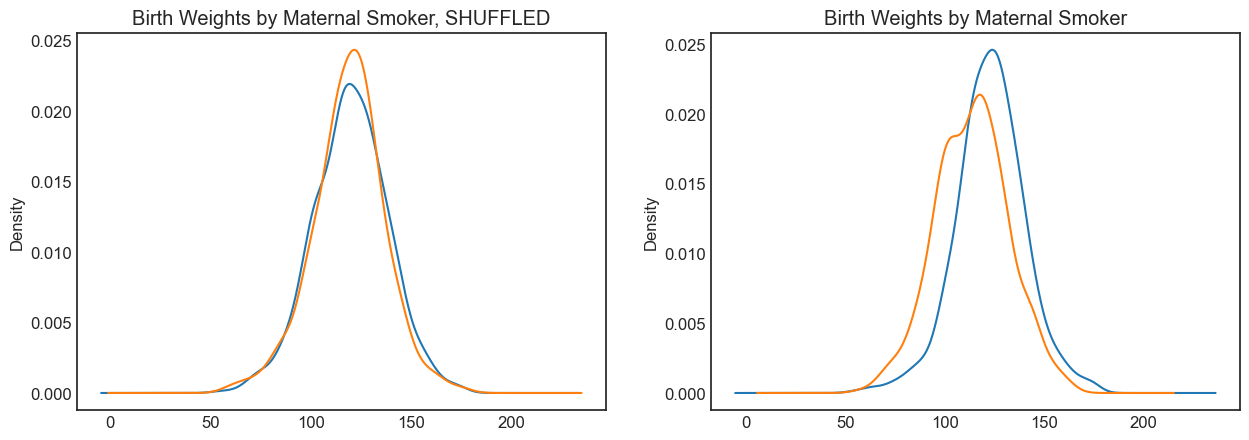

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

title = 'Birth Weights by Maternal Smoker, SHUFFLED'
original_and_shuffled.groupby('Maternal Smoker')['Shuffled Birth Weight'].plot(kind='kde', title=title, ax=axes[0])

title = 'Birth Weights by Maternal Smoker'
original_and_shuffled.groupby('Maternal Smoker')['Birth Weight'].plot(kind='kde', title=title, ax=axes[1]);

### Simulation

- This was just one random shuffle.
- The question we are trying to answer is, **how likely is it that a random shuffle results in a 9+ ounce difference in means?**
- To answer this question, we have to repeat the process of shuffling many, many times. On each iteration, we must:
    1. Shuffle the weights.
    2. Put them in a DataFrame.
    3. Compute the test statistic (difference in group means).
    4. Store the result.

In [24]:
n_repetitions = 500

differences = []
for _ in range(n_repetitions):
    
    # Step 1: Shuffle the weights
    shuffled_weights = (
        smoking_and_birthweight['Birth Weight']
        .sample(frac=1)
        .reset_index(drop=True) # Be sure to reset the index! (Why?)
    )
    
    # Step 2: Put them in a DataFrame
    shuffled = (
        smoking_and_birthweight
        .assign(**{'Shuffled Birth Weight': shuffled_weights})
    )
    
    # Step 3: Compute the test statistic
    group_means = (
        shuffled
        .groupby('Maternal Smoker')
        .mean()
        .loc[:, 'Shuffled Birth Weight']
    )
    difference = group_means.diff().iloc[-1]
    
    # Step 4: Store the result
    differences.append(difference)
    
differences[:10]

[-0.50187851364322,
 -0.36594298947240134,
 1.0613800143211876,
 1.623008364184841,
 -2.891481938540764,
 1.0184530066883042,
 -0.13699894876364738,
 -0.8953760836113815,
 -0.9168395874278303,
 -0.5197647668235987]

We already computed the observed statistic earlier, but we compute it again below to keep all of our calculations together.

In [25]:
observed_difference = (
    smoking_and_birthweight
    .groupby('Maternal Smoker')['Birth Weight']
    .mean()
    .diff()
    .iloc[-1]
)

observed_difference

-9.266142572024918

### Conclusion of the test

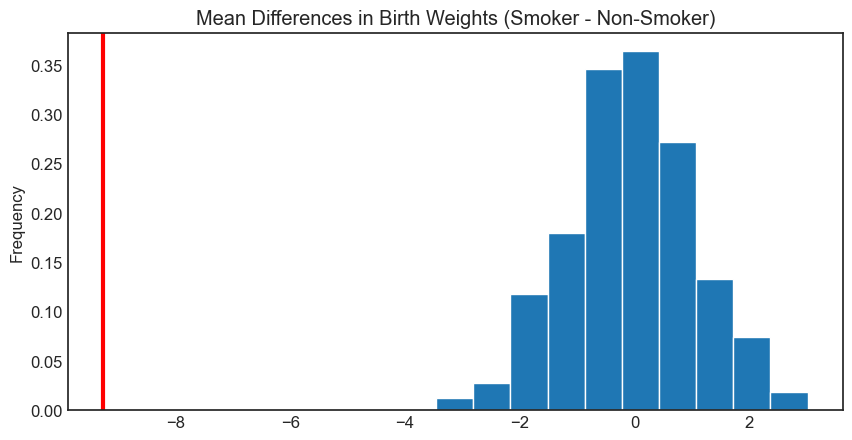

In [26]:
title = 'Mean Differences in Birth Weights (Smoker - Non-Smoker)'
pd.Series(differences).plot(kind='hist', density=True, ec='w', bins=10, title=title)
plt.axvline(x=observed_difference, color='red', linewidth=3);

- Under the null hypothesis, we rarely see differences as large as 9.26 ounces.
- Therefore, **we reject the null hypothesis that the two groups come from the same distribution**.

### ⚠️ Caution!

- We **cannot** conclude that smoking **causes** lower birth weight!
- This was an observational study; there may be confounding factors.
    - Maybe smokers are more likely to drink caffeine, and caffeine causes lower birth weight.
- We can't ethically perform a randomized controlled trial in this case. Why not?

## Differences between categorical distributions

### Example: Married vs. unmarried couples

* We will use data from a study conducted in 2010 by the [National Center for Family and Marriage Research](https://www.bgsu.edu/ncfmr.html).
* The data consists of a national random sample of over 1,000 heterosexual couples who were either married or living together but unmarried.
* Each row corresponds to one **person** (not one couple).

In [2]:
couples_fp = os.path.join('data', 'married_couples.csv')
couples = pd.read_csv(couples_fp)

In [3]:
couples.head()

,hh_id,gender,mar_status,rel_rating,age,education,hh_income,empl_status,hh_internet
0,0,1,1,1,51,12,14,1,1
1,0,2,1,1,53,9,14,1,1
2,1,1,1,1,57,11,15,1,1
3,1,2,1,1,57,9,15,1,1
4,2,1,1,1,60,12,14,1,1


We won't use all of the columns in the DataFrame.

In [4]:
couples = couples[['mar_status', 'empl_status', 'gender', 'age']]
couples.head()

,mar_status,empl_status,gender,age
0,1,1,1,51
1,1,1,2,53
2,1,1,1,57
3,1,1,2,57
4,1,1,1,60


### Cleaning the dataset

The numbers in the DataFrame correspond to the mappings below.

* `mar_status`: 1=married, 2=unmarried.
* `empl_status`: enumerated in the list below.
* `gender`: 1=male, 2=female.
* `age`: person's age in years.

In [5]:
couples.head()

,mar_status,empl_status,gender,age
0,1,1,1,51
1,1,1,2,53
2,1,1,1,57
3,1,1,2,57
4,1,1,1,60


In [6]:
empl = [
    'Working as paid employee',
    'Working, self-employed',
    'Not working - on a temporary layoff from a job',
    'Not working - looking for work',
    'Not working - retired',
    'Not working - disabled',
    'Not working - other'
]

In [7]:
couples = couples.replace({
    'mar_status': {1:'married', 2:'unmarried'},
    'gender': {1: 'M', 2: 'F'},
    'empl_status': {(k + 1): empl[k] for k in range(len(empl))}
})

In [8]:
couples.head()

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60


### Understanding the `couples` dataset

* Who is in our dataset? Mostly young people? Mostly married people? Mostly employed people?
* What is the distribution of values in each column?

In [9]:
# This cell shows the top 10 most common values in each column, along with their frequencies.
for col in couples:
    print(col)
    empr = couples[col].value_counts(normalize=True).to_frame().iloc[:10]
    display(empr)

mar_status


,mar_status
married,0.717602
unmarried,0.282398


empl_status


,empl_status
Working as paid employee,0.605899
Not working - other,0.103965
"Working, self-employed",0.098646
Not working - looking for work,0.067698
Not working - disabled,0.056576
Not working - retired,0.050774
Not working - on a temporary layoff from a job,0.016441


gender


,gender
M,0.5
F,0.5


age


,age
53,0.037234
55,0.036750
54,0.031431
40,0.030464
44,0.029981
30,0.028046
48,0.027563
49,0.027079
52,0.027079
43,0.026596


Ages are numeric, so the previous summary was not that helpful. Let's draw a histogram.

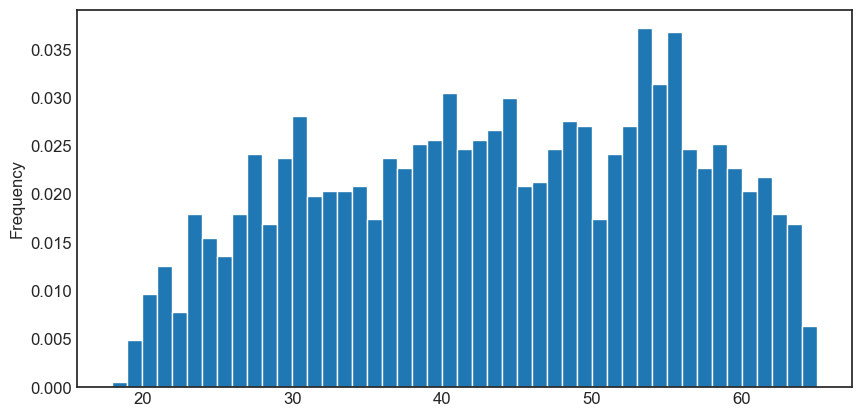

In [10]:
couples['age'].plot(kind='hist', density=True, ec='w', bins=np.arange(18, 66));

Let's look at the distribution of age **separately** for married couples and unmarried couples.

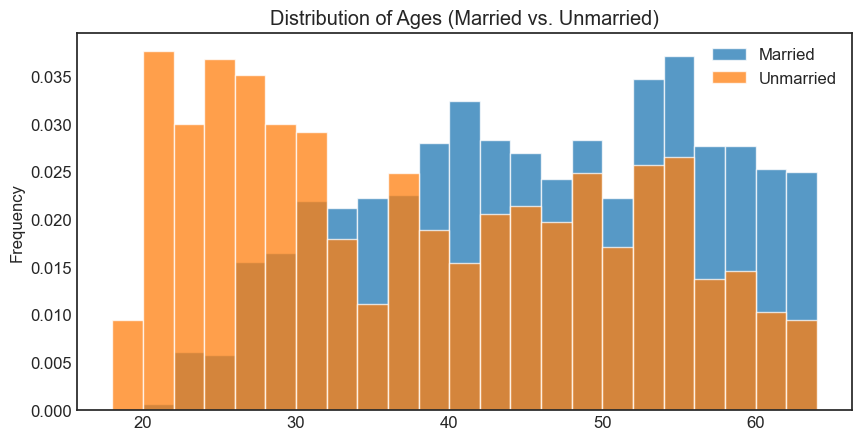

In [11]:
G = couples.groupby('mar_status')
ax = G.get_group('married')['age'].rename('Married').plot(kind='hist', density=True, alpha=0.75, 
                                                          ec='w', bins=np.arange(18, 66, 2),
                                                          legend=True, title='Distribution of Ages (Married vs. Unmarried)')
G.get_group('unmarried')['age'].rename('Unmarried').plot(kind='hist', density=True, alpha=0.75, 
                                                       ec='w', bins=np.arange(18, 66, 2),
                                                       ax=ax, legend=True);

What's the difference in the two distributions? Why do you think there is a difference?

### Understanding employment status in households

* Do married households more often have a stay-at-home spouse?
* Do households with unmarried couples more often have someone looking for work?
* How much does the employment status of the different households vary?

To answer these questions, let's compute the distribution of employment status **conditional on household type (married vs. unmarried)**.

In [12]:
couples.head()

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60


In [13]:
# Note that this is a shortcut to picking a column for values and using aggfunc='count'
empl_cnts = couples.pivot_table(index='empl_status', columns='mar_status', aggfunc='size')
empl_cnts

mar_status,married,unmarried
empl_status,,
Not working - disabled,72,45
Not working - looking for work,71,69
Not working - on a temporary layoff from a job,21,13
Not working - other,182,33
Not working - retired,94,11
Working as paid employee,906,347
"Working, self-employed",138,66


Since there are a different number of married and unmarried couples in the dataset, we can't compare the numbers above directly. We need to convert counts to proportions, separately for married and unmarried couples.

In [14]:
empl_cnts.sum()

mar_status
married      1484
unmarried     584
dtype: int64

In [15]:
cond_distr = empl_cnts / empl_cnts.sum()
cond_distr

mar_status,married,unmarried
empl_status,,
Not working - disabled,0.048518,0.077055
Not working - looking for work,0.047844,0.118151
Not working - on a temporary layoff from a job,0.014151,0.022260
Not working - other,0.122642,0.056507
Not working - retired,0.063342,0.018836
Working as paid employee,0.610512,0.594178
"Working, self-employed",0.092992,0.113014


Both of the columns above sum to 1.

### Differences in the distributions

* Are the distributions of employment status for married people and for unmarried people who live with their partners **different**?
* Is this difference just due to noise?

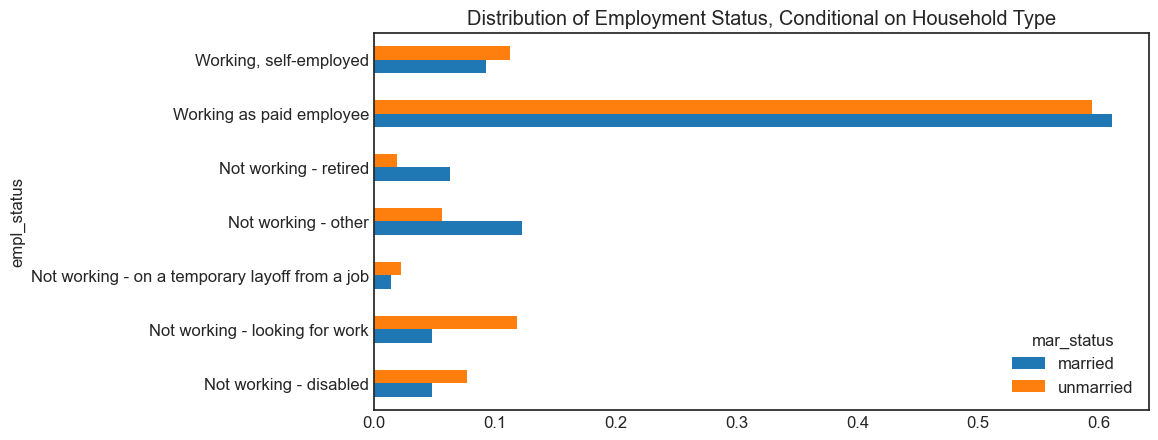

In [16]:
cond_distr.plot(kind='barh', title='Distribution of Employment Status, Conditional on Household Type');

### Permutation test for household composition 

* **Null hypothesis**: In the US, the distribution of employment status among those who are married is the same as among those who are unmarried and live with their partners. The difference between the two observed samples is due to chance.

* **Alternative hypothesis**: In the US, the distributions of employment status of the two groups are **different**.

### Discussion Question

What is a good test statistic in this case?

***Hint:*** What kind of distributions are we comparing?

### Total variation distance

- Whenever we need to compare two categorical distributions, we use the TVD.
    - Recall, the TVD is the **sum of the absolute differences in proportions, divided by 2**.
- In DSC 10, the only test statistic we ever used in permutation tests was the difference in group means/medians, but the TVD can be used in permutation tests as well.

In [17]:
cond_distr

mar_status,married,unmarried
empl_status,,
Not working - disabled,0.048518,0.077055
Not working - looking for work,0.047844,0.118151
Not working - on a temporary layoff from a job,0.014151,0.022260
Not working - other,0.122642,0.056507
Not working - retired,0.063342,0.018836
Working as paid employee,0.610512,0.594178
"Working, self-employed",0.092992,0.113014


Let's first compute the observed TVD.

In [18]:
cond_distr.diff(axis=1).iloc[:, -1].abs().sum() / 2

0.1269754089281099

Since we'll need to calculate the TVD repeatedly, let's define a function that computes it.

In [19]:
couples.head()

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60


In [20]:
def tvd_of_groups(df):
    cnts = df.pivot_table(index='empl_status', columns='mar_status', aggfunc='size')
    distr = cnts / cnts.sum()   # Normalized
    return distr.diff(axis=1).iloc[:, -1].abs().sum() / 2  # TVD

In [21]:
# Same result as above
observed_tvd = tvd_of_groups(couples)
observed_tvd

0.1269754089281099

### Simulation

- Under the null hypothesis, marital status is not related to employment status.
- We can shuffle the marital status column and get an equally-likely dataset.
- On each shuffle, we will compute the TVD.
- Once we have many TVDs, we can ask, **how often do we see a difference as large as our observed difference?**

In [22]:
couples.head()

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60


Again, let's first figure out how to perform a single shuffle. Here, we'll shuffle marital statuses. 

In [23]:
s = couples['mar_status'].sample(frac=1).reset_index(drop=True)
s

0         married
1       unmarried
2         married
3       unmarried
4         married
          ...    
2063    unmarried
2064      married
2065    unmarried
2066      married
2067      married
Name: mar_status, Length: 2068, dtype: object

In [24]:
shuffled = couples.loc[:, ['empl_status']].assign(mar_status=s)
shuffled

,empl_status,mar_status
0,Working as paid employee,married
1,Working as paid employee,unmarried
2,Working as paid employee,married
3,Working as paid employee,unmarried
4,Working as paid employee,married
...,...,...
2063,Working as paid employee,unmarried
2064,Working as paid employee,married
2065,Working as paid employee,unmarried
2066,Working as paid employee,married


In [25]:
tvd_of_groups(shuffled)

0.0269680242218366

Let's do this repeatedly.

In [26]:
N = 1000
tvds = []

for _ in range(N):
    
    s = couples['mar_status'].sample(frac=1).reset_index(drop=True)
    shuffled = couples.loc[:, ['empl_status']].assign(mar_status=s)
    
    tvds.append(tvd_of_groups(shuffled))

tvds = pd.Series(tvds)

Notice that by defining a function that computes our test statistic, our simulation code is much cleaner.

### Results

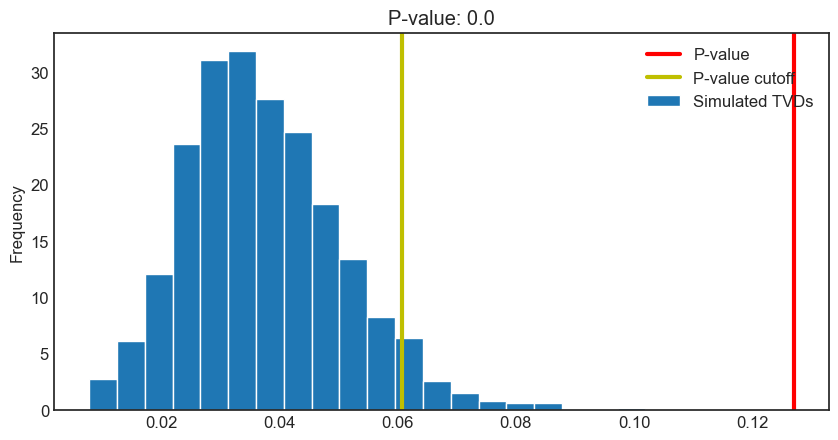

In [27]:
pval = (tvds >= observed_tvd).sum() / N
tvds.plot(kind='hist', density=True, ec='w', bins=20, title=f'P-value: {pval}', label='Simulated TVDs')
plt.axvline(x=observed_tvd, color='red', linewidth=3, label='P-value')

perc = np.percentile(tvds, 95) # 5% significance level
plt.axvline(x=perc, color='y', linewidth=3, label='P-value cutoff')

plt.legend();

### Conclusion: household composition

- We **reject** the null hypothesis that married/unmarried households have similar employment makeups.
- We can't say anything about **why** the employment makeups are different, though!

### Discussion Question

In the definition of the TVD, we divide the sum of the absolute differences in proportions between the two distributions by 2.

```py
def tvd(a, b):
    return np.sum(np.abs(a - b)) / 2
```

**Question:** If we divided by 200 instead of 2, would we still reject the null hypothesis?

### An alternative investigation

* Between the two groups (married and unmarried), is there a significant difference in the proportion of people `'Not working'`, but either `'looking for work'` or `'disabled'`?
    - In other words, is there a significant difference in the proportion of people who are out of work, not by choice?
- For each group, let's compute the average number of `'Not working – looking for work'` + `'Not working – disabled'` individuals.

In [28]:
couples.head()

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60


In [29]:
couples['empl_status'].value_counts()

Working as paid employee                          1253
Not working - other                                215
Working, self-employed                             204
Not working - looking for work                     140
Not working - disabled                             117
Not working - retired                              105
Not working - on a temporary layoff from a job      34
Name: empl_status, dtype: int64

The Series `isin` method will be helpful here.

In [30]:
not_work_no_choice = couples['empl_status'].isin(['Not working - looking for work', 'Not working - disabled'])
not_work_no_choice

0       False
1       False
2       False
3       False
4       False
        ...  
2063    False
2064    False
2065    False
2066    False
2067    False
Name: empl_status, Length: 2068, dtype: bool

In [31]:
couples['not_work_no_choice'] = not_work_no_choice.replace({True: 1, False: 0})
couples.head(12)

,mar_status,empl_status,gender,age,not_work_no_choice
0,married,Working as paid employee,M,51,0
1,married,Working as paid employee,F,53,0
2,married,Working as paid employee,M,57,0
3,married,Working as paid employee,F,57,0
4,married,Working as paid employee,M,60,0
5,married,Working as paid employee,F,57,0
6,married,"Working, self-employed",M,62,0
7,married,Working as paid employee,F,59,0
8,married,Not working - other,M,53,0
9,married,Not working - retired,F,61,0


Let's group by `mar_status` once again.

In [32]:
couples.groupby('mar_status')['not_work_no_choice'].mean()

mar_status
married      0.096361
unmarried    0.195205
Name: not_work_no_choice, dtype: float64

Notice this is not a cateogrical distribution, so we don't need to use the TVD. Instead, we can just compute the difference in group means.

In [33]:
obs_mean = couples.groupby('mar_status')['not_work_no_choice'].mean().diff().iloc[-1]
obs_mean

0.0988442934682273

### Simulation

In [34]:
N = 1000
means = []

for _ in range(N):
    
    s = couples['mar_status'].sample(frac=1).reset_index(drop=True)
    shuffled = couples.loc[:, ['not_work_no_choice']].assign(mar_status=s)

    m = shuffled.groupby('mar_status')['not_work_no_choice'].mean().diff().iloc[-1]
    
    means.append(m)

means = pd.Series(means)

### Results

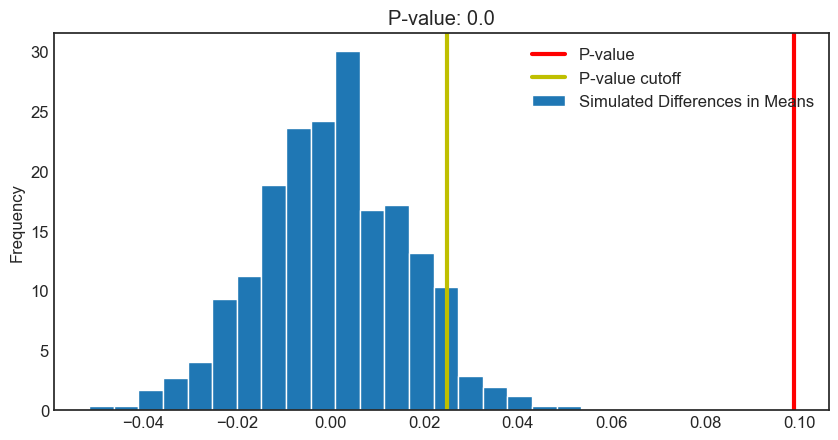

In [35]:
pval = (means >= obs_mean).sum() / N
means.plot(kind='hist', density=True, ec='w', bins=20, title=f'P-value: {pval}', label='Simulated Differences in Means')
plt.axvline(x=obs_mean, color='red', linewidth=3, label='P-value')

perc = np.percentile(means, 95) # 5% significance level
plt.axvline(x=perc, color='y', linewidth=3, label='P-value cutoff')

plt.legend();

### Conclusion: Household composition; not working, not by choice

Again, we **reject** the null hypothesis that married/unmarried households are similarly composed of those not working (not by choice) and otherwise.

## Speeding things up 🏃

### Recap: permutation tests

- Permutation tests help decide whether **two samples came from the same distribution**.
- In a permutation test, we simulate data under the null by **shuffling** either group labels or numerical features.
    - In effect, this **randomly assigns individuals to groups**.
- If the two distributions are numeric, we use as our test statistic the difference in group means or medians.
- If the two distributions are categorical, we use as our test statistic the total variation distance (TVD).



### Speeding up permutation tests

- A permutation test, like all simulation-based hypothesis tests, generates an **approximation** of the distribution of the test statistic.
    - If we found **all** permutations, the distribution would be exact!
    - If there are $a$ elements in one group and $b$ in the other, the total number of permutations is ${a + b \choose a}$.
    - If $a = 100$ and $b = 150$, there are more than ${250 \choose 100} \approx 6 \cdot 10^{71}$ permutations!

- The more repetitions we use, the better our approximation will be.
- Unfortunately, our code is pretty slow, so we can't use many repetitions.

### Example: Birth weight and smoking 🚬

In [2]:
baby_fp = os.path.join('data', 'baby.csv')
baby = pd.read_csv(baby_fp)
smoking_and_birthweight = baby[['Maternal Smoker', 'Birth Weight']]

In [3]:
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


Recall our permutation test from last class:
- **Null hypothesis**: In the population, birth weights of smokers and non-smokers have the same distribution. The difference we saw was due to random chance.
- **Alternative hypothesis**: In the population, babies born to smokers have lower birth weights, on average.

### Timing the birth weights example ⏰

We'll use 3000 repetitions instead of 500.

In [4]:
%%time

n_repetitions = 3000
differences = []

for _ in range(n_repetitions):
    
    # Step 1: Shuffle the weights
    shuffled_weights = (
        smoking_and_birthweight['Birth Weight']
        .sample(frac=1)
        .reset_index(drop=True) # Be sure to reset the index! (Why?)
    )
    
    # Step 2: Put them in a DataFrame
    shuffled = (
        smoking_and_birthweight
        .assign(**{'Shuffled Birth Weight': shuffled_weights})
    )
    
    # Step 3: Compute the test statistic
    group_means = (
        shuffled
        .groupby('Maternal Smoker')
        .mean()
        .loc[:, 'Shuffled Birth Weight']
    )
    difference = group_means.diff().iloc[-1]
    
    # Step 4: Store the result
    differences.append(difference)
    
differences[:10]

CPU times: user 2.94 s, sys: 8.57 ms, total: 2.95 s
Wall time: 2.95 s


[-0.1155354449472128,
 1.7303258832670565,
 -0.3373249843838124,
 -0.19781220957690948,
 0.10625409448938683,
 -0.35163398692809267,
 1.304633057574236,
 -1.2674101497630943,
 -1.9220470161646688,
 1.1973155384920062]

### Minor improvements

**Improvement 1:** Use `np.random.permutation` instead of `df.sample`.

**Why?** This way, we don't need to shuffle index as well. This is how you ran permutation tests in DSC 10.

In [5]:
to_shuffle = smoking_and_birthweight.copy()
weights = to_shuffle['Birth Weight']

In [6]:
%%timeit
np.random.permutation(weights.values)

22.1 µs ± 84.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%%timeit
weights.sample(frac=1)

66.4 µs ± 173 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Improvement 2:** Don't use `assign`; instead, add the new column in-place.

**Why?** This way, we don't create a new copy of our DataFrame on each iteration.

In [8]:
%%timeit
to_shuffle['Shuffled Birth Weight'] = np.random.permutation(weights.values)

47.3 µs ± 248 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
to_shuffle.assign(**{'Shuffled Birth Weight': np.random.permutation(weights.values)})

123 µs ± 620 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Let's try out both of these improvements, again with 3000 repetitions.

In [10]:
%%time

n_repetitions = 3000
faster_differences = []

to_shuffle = smoking_and_birthweight.copy()
weights = to_shuffle['Birth Weight'].values

for _ in range(n_repetitions):
    
    # Step 1: Shuffle the weights
    shuffled_weights = np.random.permutation(weights)
    
    # Step 2: Put them in a DataFrame
    to_shuffle['Shuffled Birth Weight'] = shuffled_weights
    
    # Step 3: Compute the test statistic
    group_means = (
        to_shuffle
        .groupby('Maternal Smoker')
        .mean()
        .loc[:, 'Shuffled Birth Weight']
    )
    difference = group_means.diff().iloc[-1]
    
    # Step 4: Store the result
    faster_differences.append(difference)
    
faster_differences[:10]

CPU times: user 1.96 s, sys: 6.55 ms, total: 1.97 s
Wall time: 1.97 s


[1.0077212547800656,
 1.53715434891906,
 1.2259335435805951,
 -0.4732605085546169,
 -0.7487088075323385,
 -0.11195819431112852,
 -1.843347502171028,
 -1.0491978609625647,
 -0.1763487057604749,
 -0.46610600728247675]

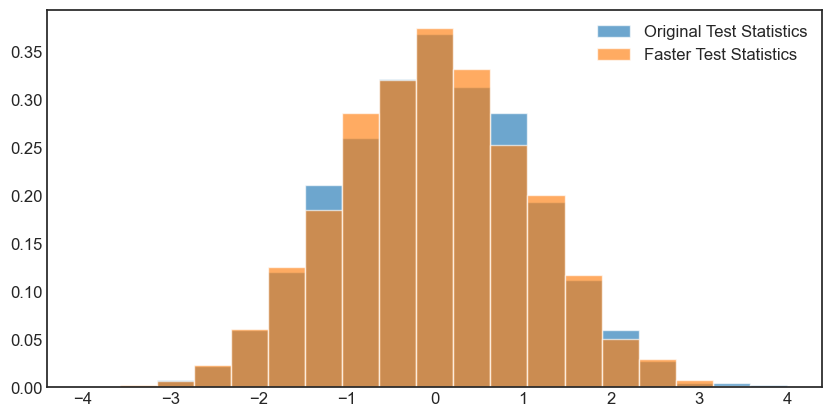

In [11]:
bins = np.linspace(-4, 4, 20)
plt.hist(differences, density=True, ec='w', bins=bins, alpha=0.65, label='Original Test Statistics');
plt.hist(faster_differences, density=True, ec='w', bins=bins, alpha=0.65, label='Faster Test Statistics')
plt.legend();

The distribution of test statistics generated by the faster approach resembles the distribution of test statistics generated by the original approach. Both are doing the same thing!

### An _even faster_ approach

- Both of our previous approaches involved calling `groupby` inside of a loop.
- We can avoid `groupby` entirely!
- Let's start by generating a Boolean array of size `(3000, 1174)`.
    - Each row will correspond to a single permutation of the `'Maternal Smoker'` (`bool`) column.

In [12]:
is_smoker = smoking_and_birthweight['Maternal Smoker'].values
weights = smoking_and_birthweight['Birth Weight'].values

In [13]:
is_smoker

array([False, False,  True, ...,  True, False, False])

In [14]:
%%time

np.random.seed(24) # So that we get the same results each time (for lecture)

# We are still using a for-loop!
is_smoker_permutations = np.column_stack([
    np.random.permutation(is_smoker)
    for _ in range(3000)
]).T

CPU times: user 167 ms, sys: 86.1 ms, total: 253 ms
Wall time: 105 ms


In `is_smoker_permutatons`, each row is a new simulation. 
- `False` means that baby comes from a non-smoking mother.
- `True` means that baby comes from a smoking mother.

In [15]:
is_smoker_permutations

array([[ True,  True, False, ...,  True,  True, False],
       [ True, False,  True, ...,  True, False, False],
       [False,  True, False, ...,  True, False,  True],
       ...,
       [False, False,  True, ..., False, False,  True],
       [ True,  True, False, ...,  True, False,  True],
       [ True,  True,  True, ..., False,  True,  True]])

In [16]:
is_smoker_permutations.shape

(3000, 1174)

Note that each row has 459 `True`s and 715 `False`s – it's just the order of them that's different.

In [17]:
is_smoker_permutations.sum(axis=1)

array([459, 459, 459, ..., 459, 459, 459])

The first row of `is_smoker_permutations` tells us that in this permutation, we'll assign baby 1 to "smoker", baby 2 to "smoker", baby 3 to "non-smoker", and so on.

In [18]:
is_smoker_permutations[0]

array([ True,  True, False, ...,  True,  True, False])

### Broadcasting

- If we multiply `is_smoker_permutations` by `weights`, we will create a **new** (3000, 1174) array, in which:
    - the weights of babies assigned to "smoker" are present, and
    - the weights of babies assigned to "non-smoker" are 0.
- `is_smoker_permutations` is a "mask".

First, let's try this on just the first permutation (i.e. the first row of `is_smoker_permutations`).

In [19]:
weights * is_smoker_permutations[0]

array([120, 113,   0, ..., 130, 125,   0])

Now, on all of `is_smoker_permutations`:

In [20]:
weights * is_smoker_permutations

array([[120, 113,   0, ..., 130, 125,   0],
       [120,   0, 128, ..., 130,   0,   0],
       [  0, 113,   0, ..., 130,   0, 117],
       ...,
       [  0,   0, 128, ...,   0,   0, 117],
       [120, 113,   0, ..., 130,   0, 117],
       [120, 113, 128, ...,   0, 125, 117]])

The mean of the **non-zero** entries in a row is the mean of the weights of "smoker" babies in that permutation.

_Why can't we use `.mean(axis=1)`?_

In [21]:
n_smokers = is_smoker.sum()
mean_smokers = (weights * is_smoker_permutations).sum(axis=1) / n_smokers
mean_smokers

array([118.94117647, 118.07625272, 120.38562092, ..., 119.76688453,
       119.2745098 , 120.22222222])

In [22]:
mean_smokers.shape

(3000,)

We also need to get the weights of the non-smokers in our permutations. We can do this by "inverting" the `is_smoker_permutations` mask and performing the same calculations.

In [23]:
n_non_smokers = 1174 - n_smokers
mean_non_smokers = (weights * ~is_smoker_permutations).sum(axis=1) / n_non_smokers
mean_non_smokers

array([119.7972028 , 120.35244755, 118.86993007, ..., 119.26713287,
       119.58321678, 118.97482517])

In [24]:
test_statistics = mean_smokers - mean_non_smokers
test_statistics

array([-0.85602633, -2.27619483,  1.51569085, ...,  0.49975166,
       -0.30870698,  1.24739705])

### Putting it all together

In [25]:
%%time

is_smoker = smoking_and_birthweight['Maternal Smoker'].values
weights = smoking_and_birthweight['Birth Weight'].values
n_smokers = is_smoker.sum()
n_non_smokers = 1174 - n_smokers

is_smoker_permutations = np.column_stack([
    np.random.permutation(is_smoker)
    for _ in range(3000)
]).T

mean_smokers = (weights * is_smoker_permutations).sum(axis=1) / n_smokers
mean_non_smokers = (weights * ~is_smoker_permutations).sum(axis=1) / n_non_smokers
ultra_fast_differences = mean_smokers - mean_non_smokers

CPU times: user 110 ms, sys: 5.49 ms, total: 115 ms
Wall time: 113 ms


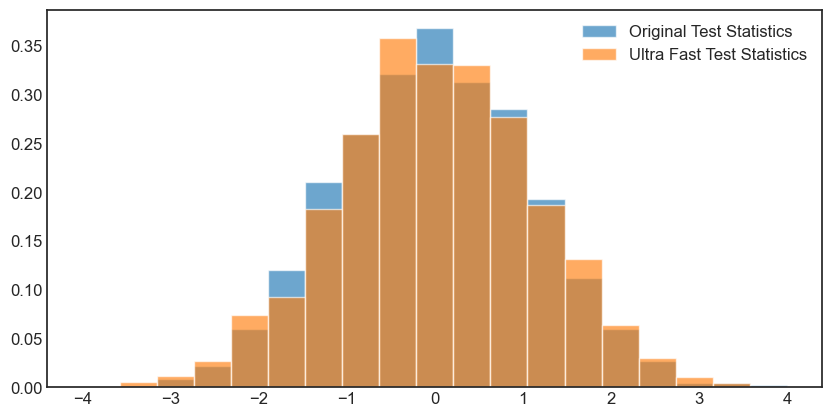

In [26]:
plt.hist(differences, density=True, ec='w', bins=bins, alpha=0.65, label='Original Test Statistics');
plt.hist(ultra_fast_differences, density=True, ec='w', bins=bins, alpha=0.65, label='Ultra Fast Test Statistics')
plt.legend();

Again, the distribution of test statistics with the "ultra-fast" simulation is similar to the original distribution of test statistics.

## Next time in DSC 80...

- Dealing with missing data.